# 0. Initial Configuration

In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys

SKELETON_DIR  = '/content/drive/MyDrive/DLE602'
# Add the SKELETON_DIR to the Python path
if SKELETON_DIR not in sys.path:
    sys.path.append(SKELETON_DIR)

# Set up auto-reloading modules from the working directory
%load_ext autoreload
%autoreload 2

In [3]:
# installing required libraries
!pip install -q -r {SKELETON_DIR}/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from config import CFG

# set configuration path and data for project
cfg = CFG(SKELETON_DIR)

# Set benchmark to True for performance improvements in cuDNN
torch.backends.cudnn.benchmark = True

# Determine the device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the default figure size for matplotlib plots
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

# 1. Initial Data Acquisition

In [5]:
# Run bash with URL from data_url variable to download dataset
!if [ ! -f "./lung-x-ray-image-clinical-text-dataset.zip" ]; then \
    echo "Dataset not found locally. Downloading..."; \
    curl -L -o ./lung-x-ray-image-clinical-text-dataset.zip "$cfg.data_url"; \
  else \
    echo "Dataset already exists. Skipping download."; \
  fi

Dataset not found locally. Downloading...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1358M  100 1358M    0     0  37.2M      0  0:00:36  0:00:36 --:--:-- 36.4M


In [6]:
# extracting the zip of dataset in a folder for easier access
%%bash
if [ ! -d "dataset" ] || [ -z "$(ls -A dataset)" ]; then
    echo "Extracting dataset..."
    rm -rf dataset
    mkdir dataset
    unzip -q -o lung-x-ray-image-clinical-text-dataset.zip -d dataset/
else
    echo "Dataset folder already exists. Skipping extraction."
fi

Extracting dataset...


In [7]:
import utils

# create a dataframe of image dataset
df = utils.create_dataframe(cfg.dataset_path)
df.head()

,path,label
0,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
1,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
2,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
3,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes
4,/content/dataset/Main dataset/Chest Changes/im...,Chest Changes


In [8]:
# give an overview of dataset
utils.dataset_overview(df)

Number of rows: 80000

Unique values per column:
image_id    78997
label           8
dtype: int64 

Label distribution:
label
Chest Changes                       10000
Lower Density                       10000
Obstructive Pulmonary Diseases      10000
Encapsulated Lesions                10000
Higher Density                      10000
Normal                              10000
Mediastinal Changes                 10000
Degenerative Infectious Diseases    10000
Name: count, dtype: int64 

Full DataFrame summary:
                                image_id          label
count                              80000          80000
unique                             78997              8
top     6da2509fc983aa9119172c809c442f74  Chest Changes
freq                                   3          10000


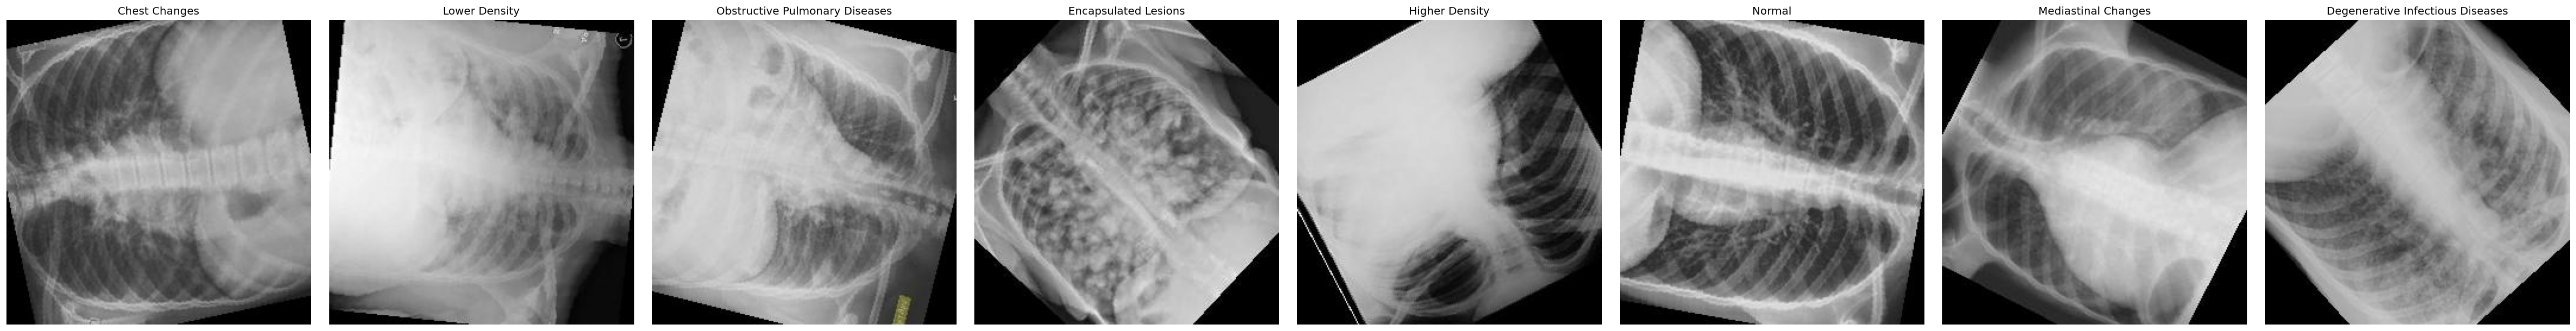

In [9]:
# show index wise one sample from each class
utils.show_images(df)

In [10]:
# initally 1000 samples from each class have been taken
samples_per_class = 2000

# Group by label and sample
df_sampled = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=samples_per_class, random_state=42))
      .reset_index(drop=True)
)

# Verify 1000 per class
print(df_sampled['label'].value_counts())
print(f"Total samples: {len(df_sampled)}")

label
Chest Changes                       2000
Degenerative Infectious Diseases    2000
Encapsulated Lesions                2000
Higher Density                      2000
Lower Density                       2000
Mediastinal Changes                 2000
Normal                              2000
Obstructive Pulmonary Diseases      2000
Name: count, dtype: int64
Total samples: 16000


/tmp/ipython-input-1487206677.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, random_state=42))


In [11]:
from sklearn.preprocessing import LabelEncoder

# create instance of label encoder
le = LabelEncoder()

# Fit the encoder and transform labels
df_sampled['label'] = le.fit_transform(df_sampled['label'])

# Check mapping of class label
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", *label_mapping.items(), sep="\n")

# Show 5 random rows from df_sampled
df_sampled.sample(10, random_state=None)

Label Mapping:
('Chest Changes', np.int64(0))
('Degenerative Infectious Diseases', np.int64(1))
('Encapsulated Lesions', np.int64(2))
('Higher Density', np.int64(3))
('Lower Density', np.int64(4))
('Mediastinal Changes', np.int64(5))
('Normal', np.int64(6))
('Obstructive Pulmonary Diseases', np.int64(7))


,path,label
613,/content/dataset/Main dataset/Chest Changes/im...,0
2575,/content/dataset/Main dataset/Degenerative Inf...,1
6995,/content/dataset/Main dataset/Higher Density/i...,3
3682,/content/dataset/Main dataset/Degenerative Inf...,1
15697,/content/dataset/Main dataset/Obstructive Pulm...,7
1045,/content/dataset/Main dataset/Chest Changes/im...,0
343,/content/dataset/Main dataset/Chest Changes/im...,0
13575,/content/dataset/Main dataset/Normal/image_535...,6
14158,/content/dataset/Main dataset/Obstructive Pulm...,7
2675,/content/dataset/Main dataset/Degenerative Inf...,1


# 2. Data Exploration

## 2.1 Image Dimension and Color Mode Analysis

In [12]:
from PIL import Image

# get image size (width, height) from file paths
sizes = df_sampled['path'].apply(lambda p: Image.open(p).size)

# get image color mode from file paths (e.g., 'L', 'RGB')
modes = df_sampled['path'].apply(lambda p: Image.open(p).mode)

print("\nImage size distribution:")
print(sizes.value_counts())

print("\nImage mode distribution:")
print(modes.value_counts())


Image size distribution:
path
(256, 256)    16000
Name: count, dtype: int64

Image mode distribution:
path
L      9162
RGB    6838
Name: count, dtype: int64


## 2.2 Data Imbalanace

Data Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Data set properly balanced


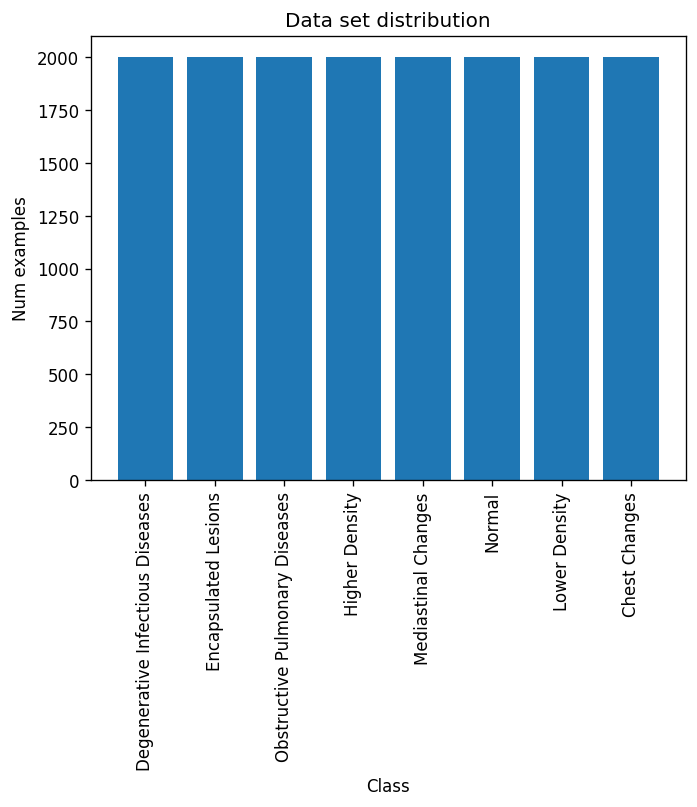

In [13]:
import explore

# class labels of all samples
labels = df_sampled['label']

# check data imbalance and present in proportion
explore.check_df_imbalance(labels, cfg.class_names)

# plot data distribution
explore.plot_label_distribution(labels, cfg.class_names)

## 2.2 Duplicates

In [14]:
explore.compute_duplicate(df)

Total rows: 80000
Duplicate rows (excluding first occurrences): 0
Duplicate groups : 0

Class-wise duplicate rows:
No  duplicates found.


## 2.3 Pixel Intensity Statistics


Overall Pixel Intensity Statistics (grayscale)
 count: 1048576000
   min: 0.0
   max: 255.0
  mean: 124.03616226768494
   std: 66.21739107820346
   class     count  min    max        mean        std
0      0  13107200  0.0  255.0  119.691640  66.150056
1      1  13107200  0.0  255.0  119.234867  64.631599
2      2  13107200  0.0  255.0  122.400504  65.819327
3      3  13107200  0.0  255.0  126.784741  69.459925
4      4  13107200  0.0  255.0  126.227008  64.393221
5      5  13107200  0.0  255.0  119.555144  63.909780
6      6  13107200  0.0  255.0  124.520564  64.629681
7      7  13107200  0.0  255.0  129.479274  68.917689


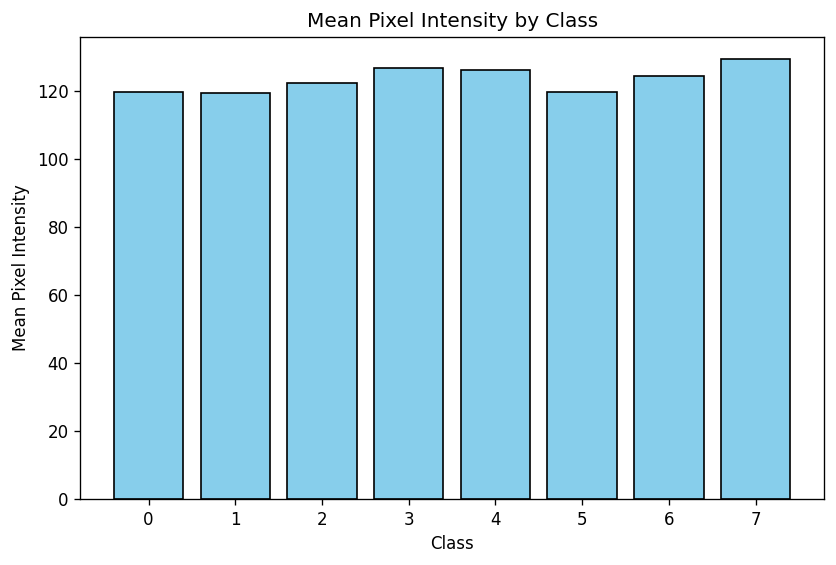

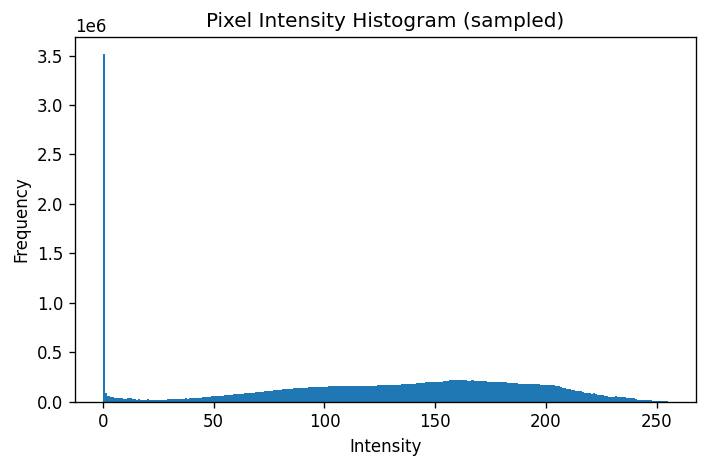

In [15]:
# print pixel intensity statistics
explore.pixel_stats_overall(df_sampled, path_col="path", as_gray=True)

# class wise pixel statistics
explore.pixel_stats_by_class(
    df_sampled, path_col="path",
    label_col="label", as_gray=True,
    sample_per_class=200
    )

# Plot histogram of mean pixel intensity based on selected samples
explore.plot_pixel_histogram(
    df_sampled, path_col="path",
    as_gray=True, bins=256, sample=500
    )

**`Findings`** – Pixel Intensity Analysis (Grayscale)
- Pixel values span the full range 0–255, confirming no clipping during preprocessing.

- The overall mean intensity (~124) suggests a moderately bright dataset.

- A large spike near intensity 0 indicates many black/dark background pixels, typical for X-ray images.

- Per-class means (116–130) and standard deviations (~62–71) are relatively close, implying no severe brightness imbalance across classes.

- The histogram shows a broad spread of intensities, meaning images retain good contrast and are not uniformly dark or bright.


# 3. Data Preparation

In [16]:
train_df, val_df, test_df = utils.split_dataset(df_sampled)

In [17]:
explore.check_df_imbalance(train_df['label'], cfg.class_names, split="Training")
print("-"*50)

explore.check_df_imbalance(val_df['label'], cfg.class_names, split="Validation")
print("-"*50)

explore.check_df_imbalance(test_df['label'], cfg.class_names, split="Testing")

Training Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Training set properly balanced
--------------------------------------------------
Validation Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Validation set properly balanced
--------------------------------------------------
Testing Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50

In [18]:
from dataset import ImageDataset

ds = ImageDataset(train_df, img_size=cfg.img_size, augment=False)
input, label = ds[0]
print(input)
print(label)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# 4. Model Training

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dataset
import models

torch.manual_seed(42)

batch_size = 64
epochs = 20
learning_rate = 0.001

train_ds = ImageDataset(train_df, img_size=cfg.img_size, augment=False)
val_ds = ImageDataset(val_df, img_size=cfg.img_size, augment=False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

## 4.1 ResNet50

In [20]:
import models

model = models.ResNet50(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


Using device: cuda:0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arifuzzamanmunaf (arifuzzamanmunaf-torrensuni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Accuracy_train,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
Accuracy_val,▁▃▄▄▄▆▆▆▇▇▇▇▇▇▇██▇██
F1_train,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
F1_val,▁▂▄▄▄▆▆▆▇▇▇▆▇▇▇██▇██
Loss_train,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Loss_val,█▆▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.75257
Accuracy_val,0.71172
F1_train,0.75106
F1_val,0.70822


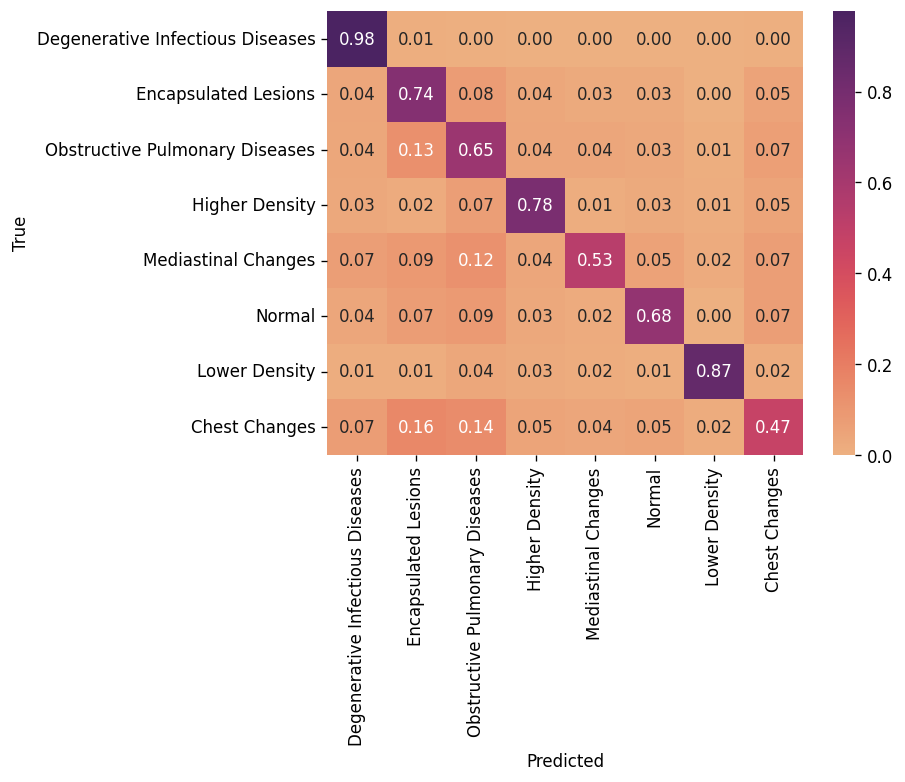

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/ResNet50_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/ResNet50_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [21]:
import train

ident_str = f"{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.2 MobileNet V3 small

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 64.7MB/s]


Accuracy_train,▁▄▆▆▆▇▇▇▇▇▇█████████
Accuracy_val,▁▁▁▂▄▆▇▇▇███████████
F1_train,▁▄▆▆▇▇▇▇▇▇▇█████████
F1_val,▁▁▁▂▄▆▇▇▇███████████
Loss_train,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Loss_val,██▇▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.77355
Accuracy_val,0.77031
F1_train,0.77235
F1_val,0.76858


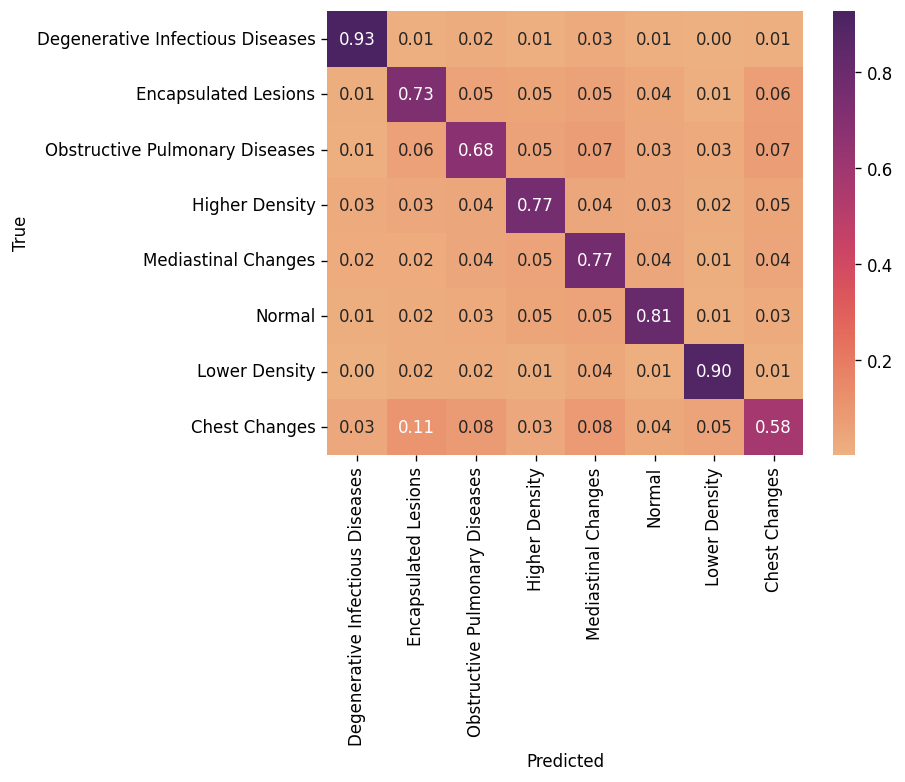

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/MobileNetV3Small_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/MobileNetV3Small_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [23]:
model = models.MobileNetV3Small(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

ident_str = f"{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )

## 4.3 Custom CNN model with residual/skip block

Using device: cuda:0


Accuracy_train,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇████
Accuracy_val,▁▃▂▃▃▅▅▅▆▇▇▆▆▇▇▆████
F1_train,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇████
F1_val,▁▃▂▃▄▅▅▆▆▇▇▆▆▇▇▇████
Loss_train,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
Loss_val,█▆▇▆▆▄▄▄▃▃▂▃▃▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Accuracy_train,0.8721
Accuracy_val,0.89792
F1_train,0.87206
F1_val,0.8977


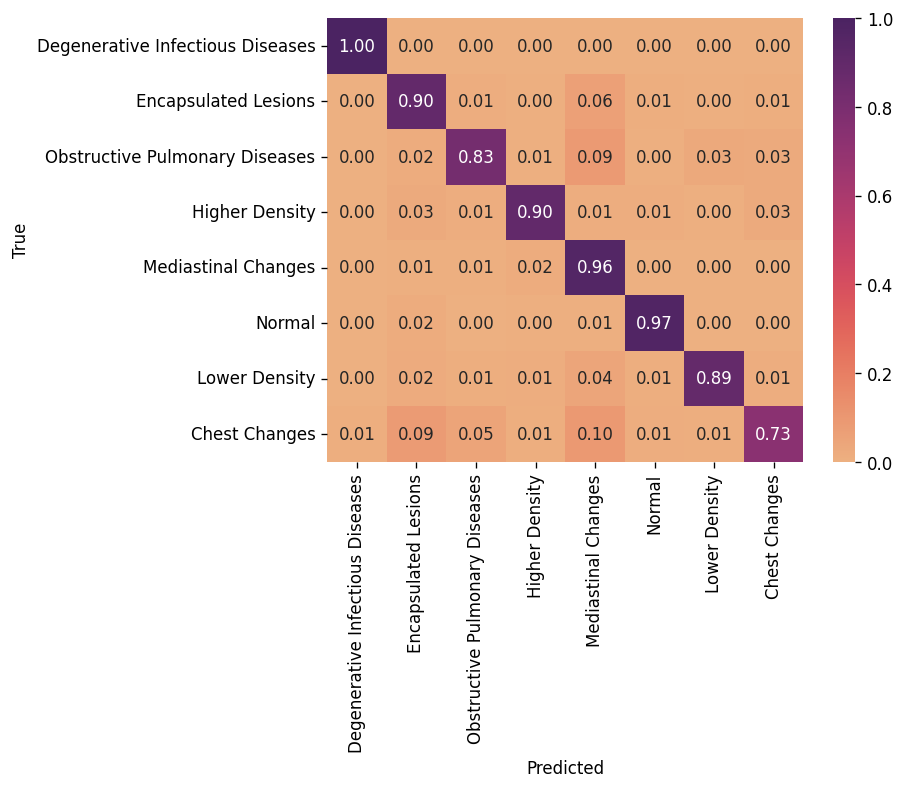

Model weights saved to: /content/drive/MyDrive/DLE602/saved_models/CustomResidualCNN_Adam_CrossEntropyLoss_20_64_0.001.pth


'/content/drive/MyDrive/DLE602/saved_models/CustomResidualCNN_Adam_CrossEntropyLoss_20_64_0.001.pth'

In [26]:
model = models.CustomResidualCNN(number_of_classes=cfg.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

ident_str = f"{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{epochs}_{batch_size}_{learning_rate}"

train.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    class_names=cfg.class_names,
    n_epochs=epochs,
    project_name="DLE602_Assessment_3",
    ident_str=ident_str
    )